# 1. Install Necessary Libraries

In [99]:
%%capture --no-stderr
%pip install -U --quiet langchain langgraph langchain_openai
%pip install -U --quiet tavily-python

# 2. Import necessary dependencies and set environment variables

In [101]:
import getpass
import os


def _set_if_undefined(var: str) -> None:
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var)


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")

# Agentic System

Agentic System

An Agentic System, in the context of AI, refers to a system where one or more Agents are involved. These agents are not just passive entities that respond to commands but exhibit characteristics like:

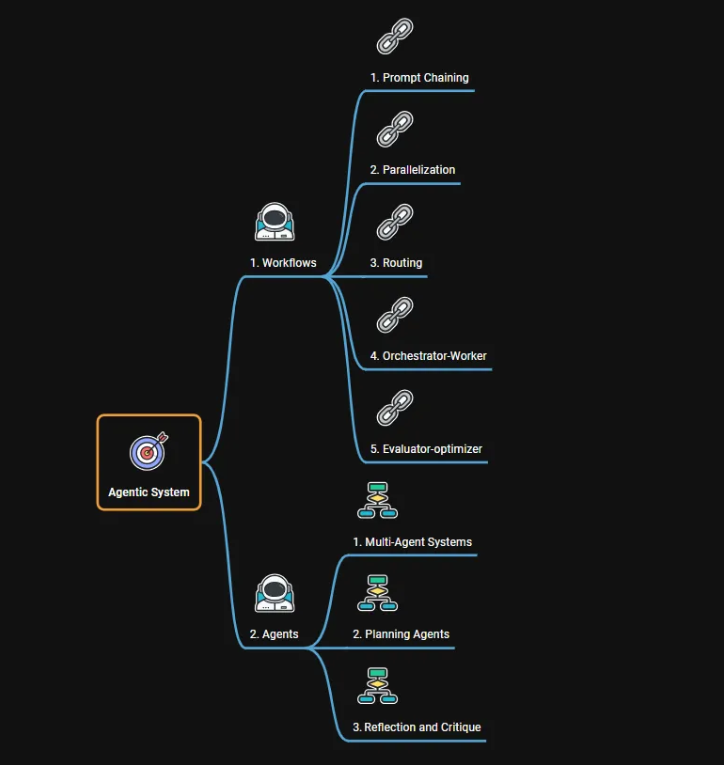

Detailed blog : https://aiproductplaybook.substack.com/p/101-what-the-heck-are-agentic-system

# 3. Reflection and Critique ( Language Agent Tree Search)

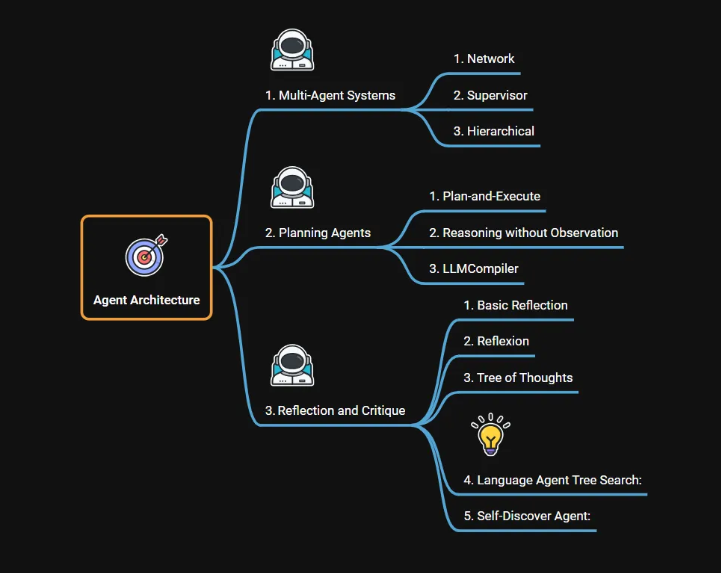

Detailed blog : https://aiproductplaybook.substack.com/p/what-the-heck-are-language-agent

### a. Language Agent Tree Search

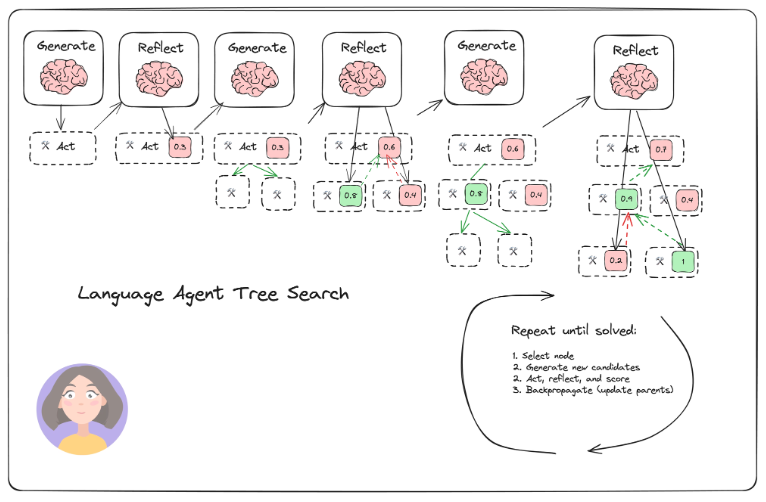

### b. Define the Node class in Search tree

1. Import necessary dependencies

2. Reflection Class

a. This class uses Pydantic to structure the reflections on a generated response.

b. reflections: A string containing the critique and reflections on the response.

c. score: An integer score (0-10) representing the quality of the response.

d. found_solution: A boolean indicating whether the response fully solved the task.

e. as_message(): Converts the reflection into a LangChain HumanMessage. This is useful for including the reflection in the conversation history.

f. normalized_score: A property that returns the score normalized to a float between 0.0 and 1.0.

3. Node Class

a. Constructor (__init__):

messages: A list of BaseMessage objects, representing the conversation history up to this node.

reflection: A Reflection object containing the reflections on the response at this node.

parent: The parent Node in the tree (can be None for the root node).

Initializes attributes like children (a list to store child nodes), value (a score for the node), visits (how many times the node has been visited during the search), depth, and _is_solved.

If the node represents a solved state (reflection.found_solution is True), it calls _mark_tree_as_solved() to mark all its ancestors as solved as well.

Calls backpropagate() to update the value of the node and its ancestors.

b. __repr__: Returns a string representation of the node for debugging.

c. is_solved Property: Returns True if the node (or any of its descendants) represents a solved state.

d. is_terminal Property: Returns True if the node has no children (it's a leaf node).

e. best_child_score Property: Returns the child node with the highest value (or None if there are no children).  It prioritizes solved children.

f. height Property: Returns the height of the subtree rooted at this node.

g. upper_confidence_bound(exploration_weight=1.0): Calculates the Upper Confidence Bound (UCB) for the node.  This is a crucial part of MCTS. It balances exploitation (choosing the best known path) and exploration (trying less-visited paths).

h. backpropagate(reward): Updates the value and visits of the node and its ancestors.  This is done after a simulation or rollout in MCTS. The reward is typically the score from the Reflection object.

i. get_messages(include_reflections=True): Returns the list of messages associated with the node, optionally including the reflection as a HumanMessage.

j. get_trajectory(include_reflections=True): Returns the full trajectory of messages from the root node to this node, optionally including reflections.

k. _get_all_children(): Returns a list of all children (and descendants) of the node using a breadth-first search.

l. get_best_solution(): Returns the best solution (terminal node that is solved) found in the subtree rooted at this node.

m. _mark_tree_as_solved(): Recursively marks all ancestor nodes as solved if a solution is found.

summary

The Node class represents a node in a search tree used for decision-making or planning,  in a LangChain application. It stores the conversation history (messages), a reflection on the quality of a response (reflection), and maintains statistics like value and visits for MCTS. The methods provide functionalities for calculating UCB, backpropagation, retrieving messages and trajectories, and finding the best solution within the subtree.  The inclusion of LangChain messages and the Reflection class suggest this code is part of a system that generates and evaluates responses in a conversational AI context.

In [102]:
import math
from collections import deque
from typing import Optional

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage

from pydantic import BaseModel, Field


class Reflection(BaseModel):
    reflections: str = Field(
        description="The critique and reflections on the sufficiency, superfluency,"
        " and general quality of the response"
    )
    score: int = Field(
        description="Score from 0-10 on the quality of the candidate response.",
        gte=0,
        lte=10,
    )
    found_solution: bool = Field(
        description="Whether the response has fully solved the question or task."
    )

    def as_message(self):
        return HumanMessage(
            content=f"Reasoning: {self.reflections}\nScore: {self.score}"
        )

    @property
    def normalized_score(self) -> float:
        return self.score / 10.0


class Node:
    def __init__(
        self,
        messages: list[BaseMessage],
        reflection: Reflection,
        parent: Optional["Node"] = None,
    ):
        self.messages = messages
        self.parent = parent
        self.children = []
        self.value = 0
        self.visits = 0
        self.reflection = reflection
        self.depth = parent.depth + 1 if parent is not None else 1
        self._is_solved = reflection.found_solution if reflection else False
        if self._is_solved:
            self._mark_tree_as_solved()
        self.backpropagate(reflection.normalized_score)

    def __repr__(self) -> str:
        return (
            f"<Node value={self.value}, visits={self.visits},"
            f" solution={self.messages} reflection={self.reflection}/>"
        )

    @property
    def is_solved(self):
        """If any solutions exist, we can end the search."""
        return self._is_solved

    @property
    def is_terminal(self):
        return not self.children

    @property
    def best_child_score(self):
        """Return the child with the highest value."""
        if not self.children:
            return None
        return max(self.children, key=lambda child: int(child.is_solved) * child.value)

    @property
    def height(self) -> int:
        """Check for how far we've rolled out the tree."""
        if self.children:
            return 1 + max([child.height for child in self.children])
        return 1

    def upper_confidence_bound(self, exploration_weight=1.0):
        """Return the UCT score. This helps balance exploration vs. exploitation of a branch."""
        if self.parent is None:
            raise ValueError("Cannot obtain UCT from root node")
        if self.visits == 0:
            return self.value
        # Encourages exploitation of high-value trajectories
        average_reward = self.value / self.visits
        # Encourages exploration of less-visited trajectories
        exploration_term = math.sqrt(math.log(self.parent.visits) / self.visits)
        return average_reward + exploration_weight * exploration_term

    def backpropagate(self, reward: float):
        """Update the score of this node and its parents."""
        node = self
        while node:
            node.visits += 1
            node.value = (node.value * (node.visits - 1) + reward) / node.visits
            node = node.parent

    def get_messages(self, include_reflections: bool = True):
        if include_reflections:
            return self.messages + [self.reflection.as_message()]
        return self.messages

    def get_trajectory(self, include_reflections: bool = True) -> list[BaseMessage]:
        """Get messages representing this search branch."""
        messages = []
        node = self
        while node:
            messages.extend(
                node.get_messages(include_reflections=include_reflections)[::-1]
            )
            node = node.parent
        # Reverse the final back-tracked trajectory to return in the correct order
        return messages[::-1]  # root solution, reflection, child 1, ...

    def _get_all_children(self):
        all_nodes = []
        nodes = deque()
        nodes.append(self)
        while nodes:
            node = nodes.popleft()
            all_nodes.extend(node.children)
            for n in node.children:
                nodes.append(n)
        return all_nodes

    def get_best_solution(self):
        """Return the best solution from within the current sub-tree."""
        all_nodes = [self] + self._get_all_children()
        best_node = max(
            all_nodes,
            # We filter out all non-terminal, non-solution trajectories
            key=lambda node: int(node.is_terminal and node.is_solved) * node.value,
        )
        return best_node

    def _mark_tree_as_solved(self):
        parent = self.parent
        while parent:
            parent._is_solved = True
            parent = parent.parent

### c. Define the state of tree

This code defines a TypedDict called TreeState. A TypedDict is a way to create type hints specifically for dictionaries, allowing you to specify the expected keys and their corresponding value types. This is useful for improving code readability, maintainability

In [109]:
from typing_extensions import TypedDict


class TreeState(TypedDict):
    # The full tree
    root: Node
    # The original input
    input: str

In [103]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

### d. Define the tool node

1. Import necessary dependencies

2. Tavily Search Setup

a. search = TavilySearchAPIWrapper(): Creates an instance of the TavilySearchAPIWrapper. This object handles the details of making requests to the Tavily API. It likely requires you to set the TAVILY_API_KEY environment variable.

b. tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5): Creates a TavilySearchResults tool.

api_wrapper=search: Passes the TavilySearchAPIWrapper instance to the tool, so the tool knows how to communicate with the Tavily API.

max_results=5: Specifies that the tool should retrieve a maximum of 5 search results.

3. Tool Node Creation

a. tools = [tavily_tool]: Creates a list containing the tavily_tool. ToolNode expects a list of tools. Even if you only have one tool, it needs to be in a list.

b. tool_node = ToolNode(tools=tools): Creates a ToolNode instance. This is the key part. The ToolNode takes the list of LangChain tools and wraps them so they can be used within a LangGraph. This tool_node can then be added to a LangGraph and used as part of a larger workflow.

summary

This code defines a tool_node that provides web search functionality using Tavily.  The TavilySearchAPIWrapper handles the API interaction, and the TavilySearchResults tool provides a convenient way to perform searches. The ToolNode then wraps this tool, making it compatible with the LangGraph framework.  You can then use this tool_node as a building block in your LangChain application.

In [104]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langgraph.prebuilt import ToolNode

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)
tools = [tavily_tool]
tool_node = ToolNode(tools=tools)

### e. Define the reflection chain

1. Import necessary dependencies

2. Prompt Template

a. This creates a ChatPromptTemplate. This template defines the structure of the prompt that will be sent to the LLM for reflection.

System Message: Sets the context by instructing the LLM to "Reflect and grade the assistant response...".

User Message: Includes the user's original input (question or task), which is inserted at the {input} placeholder.

Messages Placeholder: Includes the conversation history up to the candidate response. The candidate response (the AI's response that needs to be evaluated) is expected to be the last message in the candidate list.

3. Reflection LLM Chain

This creates the reflection_llm_chain. It's a LangChain pipeline that does the following:

prompt: Formats the prompt using the provided input and candidate messages.
llm.bind_tools(...): Sends the prompt to the LLM (llm is assumed to be an initialized LLM object, e.g., ChatOpenAI). Crucially, it uses LangChain's tool calling capability.

tools=[Reflection]: Tells the LLM that it can use the Reflection class (defined in your previous code) as a tool (or function). The LLM is expected to fill in the fields of the Reflection object (reflections, score, found_solution).

tool_choice="Reflection": Explicitly tells the LLM to use the Reflection tool.
PydanticToolsParser(...): Parses the LLM's output. Because we used bind_tools with the Reflection class, the LLM is expected to return a JSON object that matches the structure of the Reflection class. The PydanticToolsParser takes this JSON and creates a Reflection object.

4. reflection_chain Function

@as_runnable: This decorator (from langchain_core.runnables) makes the reflection_chain function a runnable object, meaning it can be used directly in LangChain chains or graphs.

def reflection_chain(inputs) -> Reflection:: Defines the reflection_chain function. It takes a dictionary inputs as input and is expected to return a Reflection object.

tool_choices = reflection_llm_chain.invoke(inputs): Calls the reflection_llm_chain with the provided inputs. This sends the prompt to the LLM, which is expected to return a Reflection object. The result is a list (because tool calling can return multiple results), even though in this case, we expect only one, so we take the first element.

reflection = tool_choices[0]: Extracts the Reflection object from the list of tool choices.

if not isinstance(inputs["candidate"][-1], AIMessage): reflection.
found_solution = False: This is a crucial check. It verifies that the last message in the candidate list (which should be the AI's response) is indeed an AIMessage. If it's not (e.g., if there's an error or the AI didn't provide a response), it sets reflection.found_solution to False. This prevents the system from thinking it has solved the task when it hasn't.

return reflection: Returns the Reflection object.

summary

The reflection_chain takes a user input and a conversation history (including a candidate response) as input. It then uses an LLM (with function calling) to generate a reflection on the candidate response, including a score and an indication of whether the response fully solved the task. The use of Pydantic and PydanticToolsParser ensures the output is a structured Reflection object. The @as_runnable decorator makes the reflection_chain easy to integrate into LangChain workflows. The check for AIMessage ensures that the reflection is only performed on actual AI-generated responses.

In [105]:
from langchain_core.output_parsers.openai_tools import (
    JsonOutputToolsParser,
    PydanticToolsParser,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import chain as as_runnable

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Reflect and grade the assistant response to the user question below.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="candidate"),
    ]
)

reflection_llm_chain = (
    prompt
    | llm.bind_tools(tools=[Reflection], tool_choice="Reflection").with_config(
        run_name="Reflection"
    )
    | PydanticToolsParser(tools=[Reflection])
)


@as_runnable
def reflection_chain(inputs) -> Reflection:
    tool_choices = reflection_llm_chain.invoke(inputs)
    reflection = tool_choices[0]
    if not isinstance(inputs["candidate"][-1], AIMessage):
        reflection.found_solution = False
    return reflection

### f. Define the initial response

The code sets up a chain (initial_answer_chain) that takes user input and previous messages, sends them to an LLM (along with available tools), and gets the LLM's response. The JsonOutputToolsParser is ready to parse the LLM's output if it contains a tool call.  This initial_answer_chain is likely the first step in a more complex conversational AI system.  It generates the initial candidate response, which can then be further processed, evaluated, or refined in subsequent steps.

In [106]:
from langchain_core.prompt_values import ChatPromptValue
from langchain_core.runnables import RunnableConfig

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an AI assistant.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)


initial_answer_chain = prompt_template | llm.bind_tools(tools=tools).with_config(
    run_name="GenerateInitialCandidate"
)


parser = JsonOutputToolsParser(return_id=True)

In [107]:
initial_response = initial_answer_chain.invoke(
    {"input": "Write a research report on lithium pollution."}
)
initial_response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_IxZKlJcSXNDks9mY5Nwd3UI8', 'function': {'arguments': '{"query": "lithium pollution research report"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_LZHXuxiKOgtOzzxBgkJkvuQC', 'function': {'arguments': '{"query": "impact of lithium extraction on environment"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 93, 'total_tokens': 156, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7dc335f0-db65-4432-91b9-8a0d28799920-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'lithium

### g. Define  the initial root node of a search tree

The generate_initial_response function generates the first response in the conversation, handling potential tool calls, and then uses a reflection chain to evaluate the quality of the response. The result, including the messages and the reflection, is then used to create the root node of the search tree. This function is designed to be a starting point for a more complex search or planning process within a LangGraph.

In [110]:
# Define the node we will add to the graph
def generate_initial_response(state: TreeState) -> dict:
    """Generate the initial candidate response."""
    res = initial_answer_chain.invoke({"input": state["input"]})
    parsed = parser.invoke(res)
    tool_responses = [
        tool_node.invoke(
            {
                "messages": [
                    AIMessage(
                        content="",
                        tool_calls=[
                            {"name": r["type"], "args": r["args"], "id": r["id"]}
                        ],
                    )
                ]
            }
        )
        for r in parsed
    ]
    output_messages = [res] + [tr["messages"][0] for tr in tool_responses]
    reflection = reflection_chain.invoke(
        {"input": state["input"], "candidate": output_messages}
    )
    root = Node(output_messages, reflection=reflection)
    return {
        **state,
        "root": root,
    }

### h. Define the candidate generation process

1.  generate_candidates Function

a. def generate_candidates(messages: ChatPromptValue, config: RunnableConfig):: Defines the function.

messages: Takes a ChatPromptValue as input. This likely represents the conversation history and the user's input, formatted as a LangChain chat prompt value.

config: Takes a RunnableConfig as input. This configuration object can hold settings for the execution of the chain, including the number of candidates to generate.

b. n = config["configurable"].get("N", 5): Retrieves the number of candidates to generate.

config["configurable"].get("N", 5): Looks for a key "N" in the configurable part of the config dictionary. If "N" is found, its value is used; otherwise, it defaults to 5. This allows you to easily control the number of candidates by passing a configuration.

c. bound_kwargs = llm.bind_tools(tools=tools).kwargs: Binds the available tools to the LLM.

llm.bind_tools(tools=tools): Makes the tools (a list of LangChain tools) available to the LLM. This enables the LLM to use the tools during response generation.

.kwargs: Extracts the keyword arguments that are passed to the LLM's generate method. This is necessary to include the tool information when generating multiple candidates.

d. chat_result = llm.generate(...): Generates the candidate responses.

[messages.to_messages()]: Converts the ChatPromptValue to a list of LangChain BaseMessage objects, which is the format expected by the LLM's generate method.

n=n: Specifies the number of candidate responses to generate (taken from the config).

callbacks=config["callbacks"]: Passes any callbacks (e.g., for logging or tracking progress) from the config to the LLM.

run_name="GenerateCandidates": Sets a name for the LLM run.

**bound_kwargs: Passes the keyword arguments (including tool information) to the LLM.

e. return [gen.message for gen in chat_result.generations[0]]: Extracts the generated messages.

chat_result.generations is a list of generation results. Since we're providing one prompt, chat_result.generations[0] gets the generations for that prompt.

Each element in chat_result.generations[0] is a Generation object. gen.message gets the BaseMessage object representing the generated message.

The list comprehension creates a list of these BaseMessage objects, which are the candidate responses.

2. expansion_chain

This creates a LangChain pipeline called expansion_chain.

prompt_template: The prompt template (defined in your previous code) is used to format the prompt.

| generate_candidates: The output of the prompt_template (the formatted prompt) is piped to the generate_candidates function. This means the formatted prompt is passed as the messages argument to generate_candidates.

summary

The generate_candidates function and the expansion_chain work together to generate multiple candidate responses. The expansion_chain takes a user input and conversation history, formats them into a prompt using the prompt_template, and then passes this prompt to the generate_candidates function. The generate_candidates function uses the LLM (with available tools) to generate N candidate responses, taking the number of candidates from a configuration object. The candidate responses are then returned as a list of BaseMessage objects. This setup is useful in scenarios where you want to explore multiple possible responses or actions, such as in tree search, reinforcement learning, or other decision-making processes.

In [111]:
# This generates N candidate values
# for a single input to sample actions from the environment


def generate_candidates(messages: ChatPromptValue, config: RunnableConfig):
    n = config["configurable"].get("N", 5)
    bound_kwargs = llm.bind_tools(tools=tools).kwargs
    chat_result = llm.generate(
        [messages.to_messages()],
        n=n,
        callbacks=config["callbacks"],
        run_name="GenerateCandidates",
        **bound_kwargs,
    )
    return [gen.message for gen in chat_result.generations[0]]


expansion_chain = prompt_template | generate_candidates

In [112]:
res = expansion_chain.invoke({"input": "Write a research report on lithium pollution."})
res

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nhk0ZsoKMTZBBAK8HQA5V33q', 'function': {'arguments': '{"query":"lithium pollution research report"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a4a8429f-ec85-4e1a-a77d-69cd8e854514-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'lithium pollution research report'}, 'id': 'call_nhk0ZsoKMTZBBAK8HQA5V33q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 93, 'output_tokens': 122, 'total_tokens': 215, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Zmz73JaB1Yh2CEUVzZcKmbbC', 'function': {'arguments': '{"query":"lithium pollution environmental impact research report"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata=

### i. Define the Candidate generation node

1. select(root) Function

a. This function implements the selection phase of MCTS.

b. It starts at the root node and traverses down the tree, selecting the child node with the highest Upper Confidence Bound (UCB) at each level. UCB is a formula that balances exploration (trying less visited nodes) and exploitation (choosing the best known path).

c. The loop continues until a leaf node (a node with no children) is reached.

d. The function returns the selected leaf node.

2. expand(state, config) Function

a. This function implements the expansion phase of MCTS.

b. root = state["root"]: Gets the root of the search tree from the state.

c. best_candidate: Node = select(root): Calls the select function to find the best node to expand (the leaf node selected during the selection phase).

d. messages = best_candidate.get_trajectory(): Gets the message history (trajectory) from the root to the best_candidate. This will be used as context for generating new candidate responses.

e. new_candidates = expansion_chain.invoke(...): Calls the expansion_chain (defined in your previous code) to generate N new candidate responses. It passes the original user input (state["input"]) and the message history (messages) to the chain.

f. Tool Call Handling: The code then handles tool calls (if the LLM used any). This part is similar to how tool calls were handled in the generate_initial_response function. It executes the tools and collects their responses.

g. Response Collection: The code organizes the LLM-generated responses and the tool responses (if any) into a list of output messages.

h. Reflection: The reflection_chain is called (in batch) to generate reflections for each of the new candidate responses.

i. Tree Growth: New child nodes are created for each candidate response, using the generated messages and the reflection. These child nodes are then added to the best_candidate node's children, expanding the search tree.

j. Return State: The function returns the (modified) state. The tree has been directly updated, so the function returns the state for consistency.

summary

The select function navigates the search tree to find the most promising leaf node (based on UCB). The expand function takes this selected node, generates new candidate responses (and handles tool calls), evaluates these responses using a reflection chain, and adds the new responses as children of the selected node, thus expanding the tree. These functions are essential for the MCTS algorithm, driving the exploration and exploitation of the search space to find good solutions.

In [113]:
from collections import defaultdict


def select(root: Node) -> dict:
    """Starting from the root node a child node is selected at each tree level until a leaf node is reached."""

    if not root.children:
        return root

    node = root
    while node.children:
        max_child = max(node.children, key=lambda child: child.upper_confidence_bound())
        node = max_child

    return node


def expand(state: TreeState, config: RunnableConfig) -> dict:
    """Starting from the "best" node in the tree, generate N candidates for the next step."""
    root = state["root"]
    best_candidate: Node = select(root)
    messages = best_candidate.get_trajectory()
    # Generate N candidates from the single child candidate
    new_candidates = expansion_chain.invoke(
        {"input": state["input"], "messages": messages}, config
    )
    parsed = parser.batch(new_candidates)
    flattened = [
        (i, tool_call)
        for i, tool_calls in enumerate(parsed)
        for tool_call in tool_calls
    ]
    tool_responses = [
        (
            i,
            tool_node.invoke(
                {
                    "messages": [
                        AIMessage(
                            content="",
                            tool_calls=[
                                {
                                    "name": tool_call["type"],
                                    "args": tool_call["args"],
                                    "id": tool_call["id"],
                                }
                            ],
                        )
                    ]
                }
            ),
        )
        for i, tool_call in flattened
    ]
    collected_responses = defaultdict(list)
    for i, resp in tool_responses:
        collected_responses[i].append(resp["messages"][0])
    output_messages = []
    for i, candidate in enumerate(new_candidates):
        output_messages.append([candidate] + collected_responses[i])

    # Reflect on each candidate
    # For tasks with external validation, you'd add that here.
    reflections = reflection_chain.batch(
        [{"input": state["input"], "candidate": msges} for msges in output_messages],
        config,
    )
    # Grow tree
    child_nodes = [
        Node(cand, parent=best_candidate, reflection=reflection)
        for cand, reflection in zip(output_messages, reflections)
    ]
    best_candidate.children.extend(child_nodes)
    # We have already extended the tree directly, so we just return the state
    return state

### j. Define and visualize the Graph

In [114]:
from typing import Literal

from langgraph.graph import END, StateGraph, START


def should_loop(state: TreeState):
    """Determine whether to continue the tree search."""
    root = state["root"]
    if root.is_solved:
        return END
    if root.height > 5:
        return END
    return "expand"


builder = StateGraph(TreeState)
builder.add_node("start", generate_initial_response)
builder.add_node("expand", expand)
builder.add_edge(START, "start")


builder.add_conditional_edges(
    "start",
    # Either expand/rollout or finish
    should_loop,
    ["expand", END],
)
builder.add_conditional_edges(
    "expand",
    # Either continue to rollout or finish
    should_loop,
    ["expand", END],
)

graph = builder.compile()

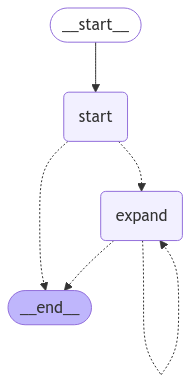

In [115]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

### k. Invoke the complete Agentic System

In [116]:
question = "Generate a table with the average goal and assist, as well as the oldest recorded goal for each of the top 5 football players in men's category."
last_step = None
for step in graph.stream({"input": question}):
    last_step = step
    step_name, step_state = next(iter(step.items()))
    print(step_name)
    print("rolled out: ", step_state["root"].height)
    print("---")

start
rolled out:  1
---
expand
rolled out:  2
---


In [117]:
solution_node = last_step["expand"]["root"].get_best_solution()
best_trajectory = solution_node.get_trajectory(include_reflections=False)
print(best_trajectory[-1].content)

Let's compile the statistics into a clear and organized table format for the top five football players as of 2023, including their average goals, average assists, and the age at which they recorded their oldest goal.

Here's the summarized information:

| Player                  | Average Goals per Season | Average Assists per Season | Oldest Recorded Goal Age |
|-------------------------|--------------------------|----------------------------|--------------------------|
| Lionel Messi            | 28                       | 12                         | 37                       |
| Cristiano Ronaldo       | 35                       | 3                          | 40                       |
| Neymar                  | 20                       | 8                          | 31                       |
| Kylian Mbappe          | 17                       | 5                          | 25                       |
| Robert Lewandowski      | 20                       | 8                         

In [118]:
question = "Generate a table with the total nunmer of  nomination and oscar winner, as well as the oldest recorded oscar nomination by year for each of the top 5 actors of all time."
last_step = None
for step in graph.stream({"input": question}):
    last_step = step
    step_name, step_state = next(iter(step.items()))
    print(step_name)
    print("rolled out: ", step_state["root"].height)
    print("---")

start
rolled out:  1
---
expand
rolled out:  2
---


In [119]:
solution_node = last_step["expand"]["root"].get_best_solution()
best_trajectory = solution_node.get_trajectory(include_reflections=False)
print(best_trajectory[-1].content)

To create a table with the total number of nominations and Oscar wins for the top 5 actors, as well as the oldest recorded Oscar nomination by year for each actor, I'll compile the information I've gathered.

### Top 5 Actors with Oscar Nominations, Wins, and Oldest Recorded Nomination

| Actor               | Total Nominations | Total Wins | Oldest Recorded Nomination Year |
|---------------------|------------------|------------|---------------------------------|
| Meryl Streep        | 21               | 3          | 1979 (The Deer Hunter)         |
| Katharine Hepburn   | 12               | 4          | 1933 (Morning Glory)           |
| Jack Nicholson      | 12               | 3          | 1970 (Easy Rider)              |
| Ingrid Bergman      | 7                | 3          | 1944 (For Whom the Bell Tolls) |
| Daniel Day-Lewis    | 6                | 3          | 1990 (My Left Foot)            |

### Notes:
- This information was extracted from the provided search results, focusin